In [54]:
import models
import utils.datasets as dataset_utils
import utils.utils as utils

import numpy as np
import os
import random
import sys
import time
import datetime
import argparse

from PIL import Image

import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator

In [67]:
parser = argparse.ArgumentParser()
parser.add_argument("--image_folder", type=str, default="data/samples", help="path to dataset")
parser.add_argument("--model_def", type=str, default="config/yolov3-tiny.cfg", help="path to model definition file")
parser.add_argument("--weights_path", type=str, default="weights/yolov3-tiny.weights", help="path to weights file")
parser.add_argument("--class_path", type=str, default="data/coco.names", help="path to class label file")
parser.add_argument("--conf_thres", type=float, default=0.8, help="object confidence threshold")
parser.add_argument("--nms_thres", type=float, default=0.4, help="iou thresshold for non-maximum suppression")
parser.add_argument("--batch_size", type=int, default=1, help="size of the batches")
parser.add_argument("--n_cpu", type=int, default=0, help="number of cpu threads to use during batch generation")
parser.add_argument("--img_size", type=int, default=208, help="size of each image dimension")
parser.add_argument("--checkpoint_model", type=str, help="path to checkpoint model")
args = parser.parse_args('')
print(args)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Namespace(batch_size=1, checkpoint_model=None, class_path='data/coco.names', conf_thres=0.8, image_folder='data/samples', img_size=208, model_def='config/yolov3-tiny.cfg', n_cpu=0, nms_thres=0.4, weights_path='weights/yolov3-tiny.weights')


In [10]:
model = models.DarknetFeaturizer(args.model_def, img_size=args.img_size).to(device)

model.load_darknet_weights(args.weights_path)
model.eval()

DarknetFeaturizer(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (maxpool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (conv_4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_4): BatchNorm2d(64, eps=1e-05, momentu

## Featurizer

torch.Size([1, 3, 160, 160])


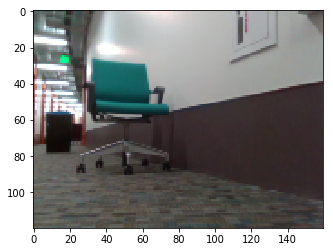

In [89]:
img = Image.open('../../data/2308.png') # 134: human, 572: bot, 767, 889, 2308: chair, 821: sofa
plt.imshow(img)

img = transforms.ToTensor()(img)
img = dataset_utils.pad_to_square(img, 0)[0].unsqueeze(0)
print(img.size())

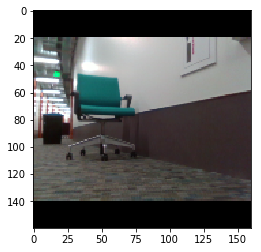

In [90]:
img1 = img.squeeze().numpy().transpose(1, 2, 0)
plt.imshow(img1)

In [91]:
img = img.to(device)
feats = model(img)

In [92]:
feats.shape

torch.Size([1, 375, 85])

## Test detection

In [93]:
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

classes = utils.load_classes(args.class_path) # Extracts class labels from file

In [94]:
model = models.Darknet(args.model_def, img_size=args.img_size).to(device)

model.load_darknet_weights(args.weights_path)

model.eval() 

with torch.no_grad():
    detections = model(img)
    detections = utils.non_max_suppression(detections, 0.1, args.nms_thres)[0]

print(detections)

tensor([[ 25.2897,  45.0383,  67.5420, 100.0406,   0.1717,   0.9236,  56.0000],
        [  3.7791,  69.9471,  19.8000, 100.1507,   0.1228,   0.5434,  56.0000]])


	+ Label: chair, Conf: 0.92362
	+ Label: chair, Conf: 0.54345


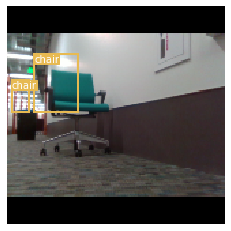

In [95]:
# plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img1)

detections = utils.rescale_boxes(detections, args.img_size, img1.shape[:2])
unique_labels = detections[:, -1].cpu().unique()
n_cls_preds = len(unique_labels)
bbox_colors = random.sample(colors, n_cls_preds)
for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

    print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

    box_w = x2 - x1
    box_h = y2 - y1

    color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
    # Create a Rectangle patch
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
    # Add the bbox to the plot
    ax.add_patch(bbox)
    # Add label
    plt.text(
        x1,
        y1,
        s=classes[int(cls_pred)],
        color="white",
        verticalalignment="top",
        bbox={"color": color, "pad": 0},
)

plt.axis("off")
plt.gca().xaxis.set_major_locator(NullLocator())
plt.gca().yaxis.set_major_locator(NullLocator())